# DL-based Stock Price Prediction Notebook
Starting with an LSTM-based predictor, inspired by https://github.com/jinglescode/time-series-forecasting-pytorch/tree/main (also on https://www.alphavantage.co/stock-prediction-deep-neural-networks-lstm/)

Now extending it to an multi-step predictor based on: https://www.geeksforgeeks.org/time-series-forecasting-using-pytorch/ and https://discuss.pytorch.org/t/predicting-future-values-with-lstm/110916/2

In [136]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Literal

from prompt_toolkit.shortcuts import set_title
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [137]:
ROOT = Path().resolve().parent

DATA = ROOT / "data"
DAILY_PRICES = DATA / "daily_price_downloads"
MINUTELY_PRICES = DATA / "minutely_price_downloads"
INTERPOLATED_PRICES = DATA / "interpolated_prices"

SAVED_MODELS = DATA / "saved_models"

## LSTM Development

In [138]:
# validation with sinus and linear function:
def create_sin_val_series(length=5000, sinus_stretch_factor=1/40,
                          sampling_freq='15min', verbose=False):
    val_series = pd.Series(np.sin(np.arange(0, length*sinus_stretch_factor,
                                             1*sinus_stretch_factor))
                            + np.linspace(0, 1, length),
                            index=pd.date_range('2020-01-01 9:00:00', None,
                                                periods=length, freq=sampling_freq))

    if verbose: val_series.plot()
    return val_series

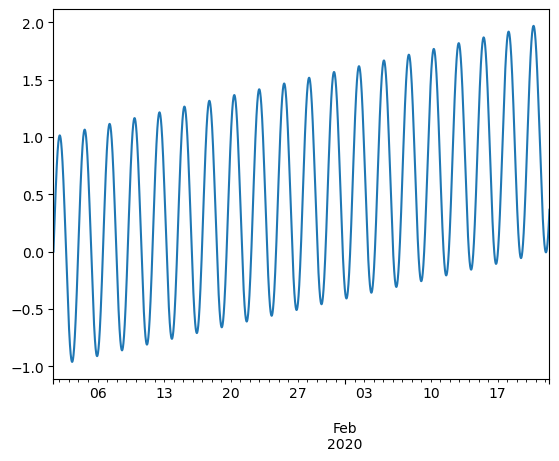

In [139]:
test_series = create_sin_val_series(verbose=True)

### Parameters

In [140]:
# data import parameters:
price_file_path = INTERPOLATED_PRICES / "2025-05-09 11_44_51  DAX Close Interpolated Prices at 15min from 2019-07-01 to 2025-04-30.csv"
# INTERPOLATED_PRICES / "2025-05-09 11_16_07  DAX Close Interpolated Prices at 1min from 2019-07-01 to 2025-04-30.csv"
# MINUTELY_PRICES / "2025-05-08 08_56_20 DAX 4. close price data 2021-07-01 to 2025-04-30.csv"
# DAILY_PRICES / "20250505 14_56_24 ^GDAXI Close price data 1987-12-30 to 2025-05-05.csv"
price_column = '4. close'  # 'Close'
date_column = 'date'  # 'Datetime'

# data preparation parameters:
validation_split = 0.15
rolling_window_size = 32  # 8 hours
forecast_horizon = 16 # 4 hours, i.e. called at 4pm for rest of day
batch_size = 32  # number of data_points to be used during training
# increase if training is stable but slow
# decrease if generalization is poor

# model parameters:
model_input_size = 1
hidden_lstm_layer_size = 64
num_lstm_layers = 4
dropout = 0.3  # regularizer to prevent overfitting
use_final_hidden_state = False  # False: use lstm_out, True: use h_n
use_pre_lstm_fc_layer = True  # apply linear and ReLu layer before lstm
init_weights = True
use_mps_if_available = False  # with this computer the CPU has often been faster than Metal Performance Shaders

# training parameters:
custom_step_weights = None  # default is linearly decreasing step weights from 1 to 0.2 for outputs further down the forecast sequence
n_epochs = 300
initial_learning_rate = 0.001
scheduler_to_use = 'plateau'  # 'plateau' or 'step'
step_scheduler_step_size = 40
plateau_scheduler_factor = 0.5
early_stopping_patience = 10  # if 0 doesn't utilise early stopping

### Data Loading

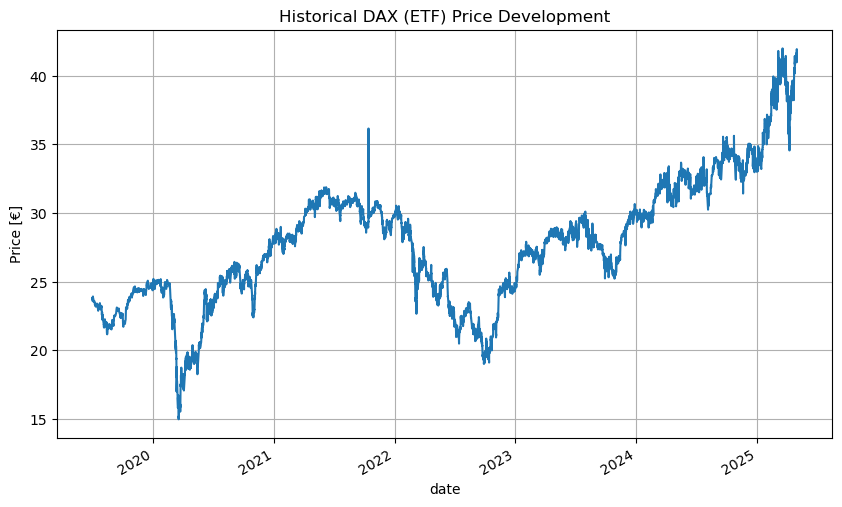

In [141]:
price_file = pd.read_csv(price_file_path)
price_file.dropna(axis=0, inplace=True)
try:
    price_file[date_column] = pd.to_datetime(price_file[date_column])
except KeyError:  # if the csv has no name for its index:
    price_file[date_column] = pd.to_datetime(price_file['Unnamed: 0'])
price_file[price_column] = price_file[price_column].astype(float) 

price_series = price_file.set_index(date_column)[price_column]
price_series.plot(ylabel='Price [€]', title='Historical DAX (ETF) Price Development', figsize=(10, 6))
plt.grid()

### Data Preparation

#### Normalisation
Scaling the data is important for convergence during model training. We utilise the *normalisation* technique.

In [142]:
class Normaliser():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        """ Normalise an array of values. """
        self.mu = np.mean(x, axis=0)
        self.sd = np.std(x, axis=0)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        """ Reverse-transform an array of normalised values. """
        if self.sd is None: raise AttributeError("Please use fit_transform first so this instance remembers the respective std. and mean values!")
        return (x*self.sd) + self.mu

In [143]:
normaliser = Normaliser()
normalised_price_series = normaliser.fit_transform(price_series)

#### Training Data
Split a share of the data (with the most recent datapoints) for model validation. 

We will train the model to predict future *forecast_horizon* prices based on the past *rolling_window_size* prices.

In [144]:
X

array([[-0.87522606, -0.86380732, -0.86241325, ..., -0.90280755,
        -0.90273915, -0.90267074],
       [-0.86380732, -0.86241325, -0.86101918, ..., -0.90273915,
        -0.90267074, -0.90260233],
       [-0.86241325, -0.86101918, -0.85962511, ..., -0.90267074,
        -0.90260233, -0.90253393],
       ...,
       [ 2.99184374,  3.00807091,  3.0014958 , ...,  2.96865918,
         2.98715669,  2.97846929],
       [ 3.00807091,  3.0014958 ,  3.0033714 , ...,  2.98715669,
         2.97846929,  3.00952374],
       [ 3.0014958 ,  3.0033714 ,  3.00363985, ...,  2.97846929,
         3.00952374,  3.00789962]], shape=(54779, 32))

In [145]:
# sliding window view as matrix: last column are current prices, 1st to (rolling-window-size - 1)th column are retrospective prices:
X = np.lib.stride_tricks.sliding_window_view(normalised_price_series.to_numpy(), window_shape=rolling_window_size)[:-forecast_horizon]  # last rows (latest values) are removed (because contained only in target values)

# target values are subsequent prices, window size here is referred to as the forecast_horizon:
Y = np.lib.stride_tricks.sliding_window_view(normalised_price_series.to_numpy(), window_shape=forecast_horizon)[rolling_window_size:]  # first rows (earliest values) are removed (because contained only in training values)

Using last 15.0% of data for validation. Other data for training.


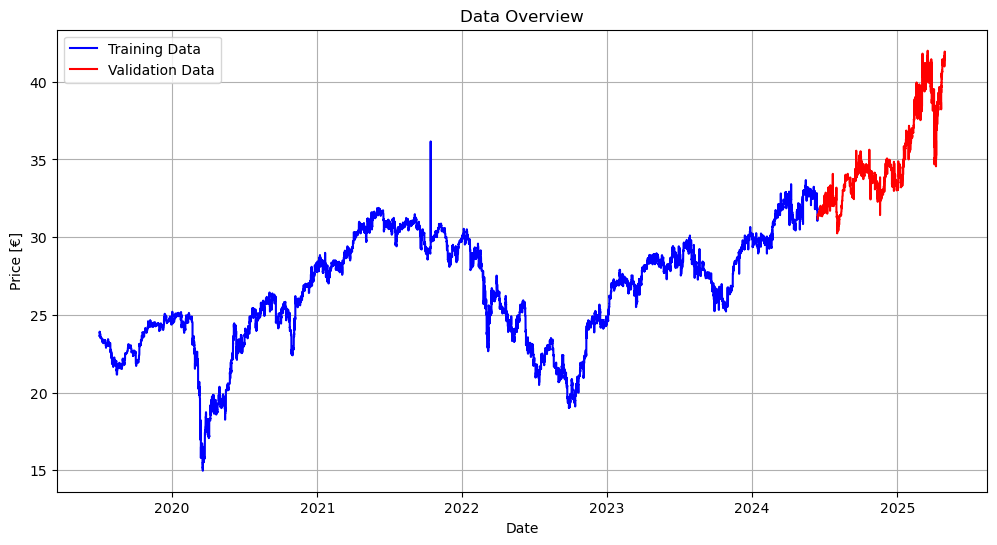

In [146]:
# split prices into training and validation data:
print(f"Using last {100 * validation_split}% of data for validation. Other data for training.")
validation_split_index = int(X.shape[0] * (1-validation_split))
X_train = X[:validation_split_index]
X_val = X[validation_split_index:]
Y_train = Y[:validation_split_index]
Y_val = Y[validation_split_index:]

# retrieve y-dates for plotting:
dates = normalised_price_series.index.to_numpy()[rolling_window_size:-forecast_horizon+1]
dates_train = dates[:validation_split_index]
dates_val = dates[validation_split_index:]

# plot result:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(dates_train, normaliser.inverse_transform(Y_train[:, -1]), label='Training Data', color='blue')
ax.plot(dates_val, normaliser.inverse_transform(Y_val[:, -1]), label='Validation Data', color='red')
ax.set_xlabel('Date')
ax.set_ylabel('Price [€]')
ax.set_title('Data Overview')
ax.grid(True)
ax.legend()

#### Pytorch Dataset and DataLoader

In [147]:
from typing import Union

class TimeSeriesDataset(Dataset):
    """ Time-series dataset class based on torch.utils.data.Dataset compatible torch.utils.data.DataLoader """
    def __init__(self,
                 x: Union[pd.DataFrame, pd.Series, np.ndarray],
                 y: Union[pd.Series, pd.Series, np.ndarray],
                 verbose=False):
        # convert values to numpy if necessary:
        if isinstance(x, (pd.Series, pd.DataFrame)):
            x = x.to_numpy()
        if isinstance(y, (pd.Series, pd.DataFrame)):
            y = y.to_numpy()
            
        # expand tensor for LSTM input w. shape (batch, sequence_length, input_size):
        x = np.expand_dims(x, 2)
        
        # sanity check:
        if x.shape[0] != y.shape[0]: raise ValueError("Mismatched number of samples.")
        
        # save values:
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
        # information:
        if verbose: print(f"Dataset Shape: {self.x.shape}, {self.y.shape}")
        
    # necessary operators:
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [148]:
dataset_train = TimeSeriesDataset(X_train, Y_train)
dataset_val = TimeSeriesDataset(X_val, Y_val)

# a data loader is an efficient data generation scheme that
# combines a dataset and a sampler, and provides an iterable over the given dataset:
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

### Define LSTM
LSTM is a specialized artificial neural network architecture that can **"memorize" patterns from historical sequences of data** and extrapolate such patterns for future events. Specifically, it belongs to a group of artificial neural networks called **Recurring Neural Networks (RNNs)**.

LSTMs overcome many technical limitations of RNNs. For example, RNNs fail to learn when the data sequence is greater than 5 to 10 due to the **vanishing gradients problem**, where the gradients are vanishingly small, effectively preventing the model from learning. LSTMs can learn long sequences of data by enforcing constant error flow through self-connected hidden layers, which contain **memory cells and corresponding gate units**. More info: https://colah.github.io/posts/2015-08-Understanding-LSTMs/.

In [173]:
# with output size equivalent to output sequenth length:
class LSTMModel(nn.Module):
    """ LSTM model class based on torch.nn.Module """
    def __init__(self,
                 input_size=1,
                 hidden_layer_size=32,
                 num_layers=2,
                 n_forecast_steps=1,  # output sequence length
                 dropout=0.2,
                 use_pre_lstm_fc_layer=False,
                 use_final_hidden_state=True,
                 init_weights=True):
        """
        Initialise the LSTM model. 
        
        :param input_size: input size of the LSTM model.
        :param hidden_layer_size: hidden size of the LSTM model.
        :param num_layers: number of LSTM layers.
        :param n_forecast_steps: number of forecast steps. If not 1, outputs will be calculated recursively for each forecast step, i.e. while feeding back previous predictions into the network.
        """
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.use_pre_lstm_fc_layer = use_pre_lstm_fc_layer
        self.n_forecast_steps = n_forecast_steps

        # optional pre-lstm fully connected layer:
        self.linear_1 = nn.Linear(input_size, hidden_layer_size) if use_pre_lstm_fc_layer else None  # transform feature into size of lstm hidden layers
        self.relu = nn.ReLU() if use_pre_lstm_fc_layer else None  # non-linearity

        # lstm layers:
        self.lstm = nn.LSTM(hidden_layer_size if use_pre_lstm_fc_layer else 1, hidden_size=self.hidden_layer_size, num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)  # batch first=True because our shape is (batch, seq, feature)
        # self.dropout = nn.Dropout(dropout)  # prevent overfitting, now is included in lstm

        self.use_final_hidden_state = use_final_hidden_state  # use lstm_out, else use h_n; see comments below in forward()

        # final fully connected layer:
        self.linear_2 = nn.Linear((num_layers if use_final_hidden_state else 1) * hidden_layer_size,
                                  1)  # transforms LSTM output into 1 price
        # when use_final_hidden_state, multiply with * num_layers to utilise all LSTM layer's final hidden states

        if init_weights: self.init_weights()  # empirically accelerates convergence

    def init_weights(self):
        for name, param in self.named_parameters():  # iterate through weights and biases
            if 'bias' in name:  # bias zero initialisation: neutral starting point
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:  # input-hidden weights with He/Kaiming initialisation w. normal distribution: preserves gradient magnitude through ReLU activations
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:  # hidden-hidden weights with orthogonal matrix initialisation: maintains norm during sequence processing and helps prevent gradient issues
                nn.init.orthogonal_(param)

    def forward(self, x):
        """ Forward call of module """
        batchsize = x.shape[0]
        
        outputs = torch.empty(size=(batchsize, self.n_forecast_steps))  # initialise empty tensor for outputs
        
        # recursive prediction (taking into account previous predictions if n_forecast_steps > 1):
        for output_sequence_ind in range(self.n_forecast_steps):
            # integrate previous predictions into input:
            if output_sequence_ind > 0:
                x = torch.roll(x, shifts=-1)  # shift all inputs back by one time unit
                x[:, -1] = torch.unsqueeze(outputs[:, output_sequence_ind-1], 1)  # replace most recent time step with last prediction
                
            if self.use_pre_lstm_fc_layer:
                # layer 1:
                temp_x = self.linear_1(x)  # we need to denote this as temp_x because we need the original input again in latter iterations
                # x = self.batch_norm(x)
                temp_x = self.relu(temp_x)
                # x.shape now is (64, 20, 32) = (batch, sequenth_length, features)
    
            # LSTM layer(s):
            lstm_out, (h_n, c_n) = self.lstm(temp_x)
    
            # which output to use?
            # - lstm_out contains **all hidden states for the last layer** for every time step, used for tasks requiring per-time-step predictions and **sequence forecasting**
            #       shape is (batchsize, sequence_length, features)
            # - h_n is a tensor containing the **final hidden state for each layer** in the sequence, used for initialing latter sequences, as summarisation for classification tasks or **one-step-forecasting**
            #       shape is (num_layers, batchsize, features)
            # - c_n is a tensor containing the **final cell state for each layer** in the sequence, used jointly with h_n for more complex forecasting purposes
            #       shape is (num_layers, batchsize, features)
            if self.use_final_hidden_state:
                # we utilise h_n because it aggregates states from all layers.
                # reshape final hidden state output from (num_layers, batchsize, features) to (batchsize, features) for consecutive linear layer:
                # permute rearranges the dimensions according to a specific order, -1 tells reshape to infer the correct size for that dimension
                temp_x = h_n.permute(1, 0, 2).reshape(batchsize, -1)  # here we flatten all layer outputs
            else:
                # we utilise lstm_out[:, -1, :]  which is the last time step of the final layer
                temp_x = lstm_out[:, -1, :]
    
            # layer 2:
            # x = self.dropout(x)  additional regularisation is spared here because happening inside LSTM
            predictions = self.linear_2(temp_x)
            outputs[:, output_sequence_ind] = predictions.squeeze(-1)  # return last column of all batches (equals predictions), squeeze removes dimensions with size 1
        
        return outputs.squeeze(-1)  # remove dimensions with size 1

    def run_epoch(self, dataloader, optimiser, device='cpu', loss_criterion=nn.MSELoss(), is_training=False):
        """ One epoch of training (is_training=True) or validation (is_training=False), returns the respective loss and learning rate as tuple. """
        epoch_loss = 0

        if is_training:
            self.train()  # training mode activates Dropout and BatchNorm (updates running statistics with each batch)
        else:
            self.eval()  # evaluation mode for inference or testing

        # iterate through dataset's batches via provided dataloader instance:
        for idx, (x, y) in enumerate(dataloader):
            if is_training: optimiser.zero_grad()  # reset all gradients for next training step

            # move tensors to correct device:
            x = x.to(device);
            y = y.to(device)

            # compute output and loss:
            out = self(x)
            loss = loss_criterion(out.contiguous(),
                                  y.contiguous())  # enforces the tensors to be stored in a contiguous memory block

            if is_training:
                loss.backward()  # backpropagation, traverses computational graph in reverse applying the chain rule to compute gradients
                optimiser.step()  # optimise weights

            epoch_loss += loss.detach().item()  # without / batchsize because loss is already averaged, detach loss value from computational graph

        # learning rate:
        lr = optimiser.param_groups[0]['lr']

        return epoch_loss, lr

    def predict(self, dataloader, device='cpu'):
        """ Compute predictions (outputs) for all samples in a dataloader. """
        self.eval()  # inference mode
        predictions = np.array([])

        # deactivate shuffling and set batch size to 1:
        temp_loader = DataLoader(dataloader.dataset, batch_size=1, shuffle=False)
        
        # compute predictions:
        with torch.no_grad():
            for idx, (x, y) in enumerate(temp_loader):
                x = x.to(device)
                out = self(x)  # run model
                out = out.cpu().detach().numpy()
                predictions = np.concatenate((predictions, out))

            return predictions


In [174]:
model1 = LSTMModel(input_size=model_input_size, hidden_layer_size=hidden_lstm_layer_size, num_layers=num_lstm_layers, dropout=dropout, n_forecast_steps=1,
                  use_final_hidden_state=use_final_hidden_state, init_weights=init_weights, use_pre_lstm_fc_layer=use_pre_lstm_fc_layer)
model1 = model1.to('cpu')

In [175]:
n_points_from_batch = 1
for x, y in dataloader_train:
    print('X shape:', x[0:n_points_from_batch, :, :].shape, )
    output = model1(x[0:n_points_from_batch, : :])
    print('Y shape:', y[0:n_points_from_batch, :].shape, '\nOutput shape:', output.shape)
    print(y[0:n_points_from_batch, :])
    print(output)  # first sequence of batch with
    print(type(output))
    break

X shape: torch.Size([1, 32, 1])
0
Y shape: torch.Size([1, 16]) 
Output shape: torch.Size([1])
tensor([[-0.4101, -0.4108, -0.4116, -0.4123, -0.4130, -0.4137, -0.4144, -0.4151,
         -0.5946, -0.5953, -0.6175, -0.6199, -0.6390, -0.6671, -0.7151, -0.6985]])
tensor([-0.0213], grad_fn=<SqueezeBackward1>)
<class 'torch.Tensor'>


### Model Training
For training we utilise the **Adam optimiser** with **StepLR scheduler** to sequentially reduce the learning rate (other possibility: **ReduceLROnPlateau scheduler**) and **MSE-loss**

In [176]:
class WeightedMSELoss(nn.Module):
    def __init__(self, step_weights=None):
        """ Weighted MSE Loss. If step_weights is None, weights all predictions equally. """
        super().__init__()
        self.step_weights = step_weights
        
    def forward(self, predictions, targets):
        # predictions and target shape: [batch_size, n_steps]
        if self.step_weights is None:  # equal weighting
            return torch.mean((predictions - targets) ** 2)  # MSE formula
        else:  # weighted loss
            losses = (predictions - targets) ** 2
            weighted_losses = losses * torch.Tensor(self.step_weights, device=predictions.device)  # calculate weighted loss tensor
            return torch.mean(weighted_losses)
        
loss_criterion = WeightedMSELoss(step_weights=np.linspace(1, 0.2, forecast_horizon) if custom_step_weights is None else custom_step_weights)

In [177]:
def run_training(model, n_epochs: int, dataloader_train, dataloader_val, step_scheduler_step_size: int = 40, plateau_scheduler_factor=0.1, scheduler_to_use: Literal['step', 'plateau'] ='step',
                 initial_learning_rate: float = 0.01, device='cpu', loss_criterion=nn.MSELoss(), early_stopping_patience=0):
    # initialise optimiser and scheduler:
    optimiser = optim.Adam(model.parameters(), lr=initial_learning_rate, betas=(0.9, 0.98), eps=1e-9)  # beta and eps are standard values derived from github
    if scheduler_to_use == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimiser, step_scheduler_step_size, gamma=0.1)
    elif scheduler_to_use == 'plateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, factor=plateau_scheduler_factor, patience=5)
    else:
        raise ValueError("scheduler_to_use has to be either 'step' or 'plateau'!")

    # training loop:
    progress_bar = tqdm(range(n_epochs), desc=f'Train loss: - | Val Loss: - | Patience {'/' if early_stopping_patience == 0 else f'{0}/{early_stopping_patience}'} | LRate: - | Progress')
    loss_train_history, loss_val_history = [], []
    for epoch in progress_bar:
        loss_train, lr_train = model.run_epoch(dataloader_train, optimiser=optimiser, device=device, loss_criterion=loss_criterion, is_training=True)
        loss_val, _ = model.run_epoch(dataloader_val, optimiser=optimiser, device=device, loss_criterion=loss_criterion, is_training=False)

        # scheduler step:
        if scheduler_to_use == 'plateau': scheduler.step(loss_val)
        else: scheduler.step()

        loss_train_history.append(loss_train); loss_val_history.append(loss_val)

        # early stopping check:
        if early_stopping_patience != 0:
            # initialisation of vars in epoch 0:
            if epoch == 0:
                best_loss = loss_val
                counter = 0
                continue
            # validation loss improved:
            if loss_val < best_loss:
                best_loss = loss_val
                counter = 0
            else:  # validation loss didn't improve
                counter += 1
                if counter >= early_stopping_patience:
                    print("Early stopping triggered at validation loss of", loss_val)
                    n_epochs = epoch + 1
                    break

        # progress bar for visualisation:
        progress_bar.desc = f'Train loss: {loss_train} | Val Loss: {loss_val}  | Patience {'/' if early_stopping_patience == 0 else f'{counter}/{early_stopping_patience}'} | LRate: {lr_train} | Progress'


    # loss progression plot:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(range(n_epochs), loss_train_history, label='Training loss', color='blue')
    ax.plot(range(n_epochs), loss_val_history, label='Validation loss', color='red')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.grid(True)
    ax.legend()
    ax.set_title('Training Progress')

In [178]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # if ROCm is installed and AMD hardware is supported by such then 'cuda' also refers to AMD GPU acceleration. This however is not possible on mac
    print("Using GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))
elif torch.backends.mps.is_available() and use_mps_if_available:
    device = torch.device('mps')
    print("Using GPU through Metal Performance Shaders (MPS) backend")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using CPU


### Parameter Optimisation

#### Model 1

In [179]:
model1 = LSTMModel(input_size=model_input_size, hidden_layer_size=hidden_lstm_layer_size, num_layers=num_lstm_layers, dropout=dropout, n_forecast_steps=forecast_horizon,
                  use_final_hidden_state=use_final_hidden_state, init_weights=init_weights, use_pre_lstm_fc_layer=use_pre_lstm_fc_layer)
model1 = model1.to(device)

In [180]:
run_training(model=model1, n_epochs=n_epochs, dataloader_train=dataloader_train, dataloader_val=dataloader_val,
             step_scheduler_step_size=step_scheduler_step_size, plateau_scheduler_factor=plateau_scheduler_factor, scheduler_to_use=scheduler_to_use,
             initial_learning_rate=initial_learning_rate,
             device=device, loss_criterion=loss_criterion,
             early_stopping_patience=early_stopping_patience
             )

Train loss: - | Val Loss: - | Patience 0/10 | LRate: - | Progress:   0%|          | 0/300 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


Train loss: - | Val Loss: - | Patience 0/10 | LRate: - | Progress:   0%|          | 0/300 [00:05<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13


KeyboardInterrupt: 

In [5]:
predictions_train = model1.predict(dataloader_train, device=device)
predictions_val = model1.predict(dataloader_val, device=device)

# plot result:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(dates_train, normaliser.inverse_transform(Y_train), label='Training Prices', color='black')
ax.plot(dates_train, normaliser.inverse_transform(predictions_train), label='Predicted Prices (Training)', color='blue')
ax.plot(dates_val, normaliser.inverse_transform(predictions_val), label='Predicted Prices (Validation)', color='red')

ax.set_xlabel('Date')
ax.set_ylabel('Price [€]')
ax.set_title('Data Overview')
ax.grid(True)
ax.legend()

NameError: name 'model1' is not defined

Narrower view:

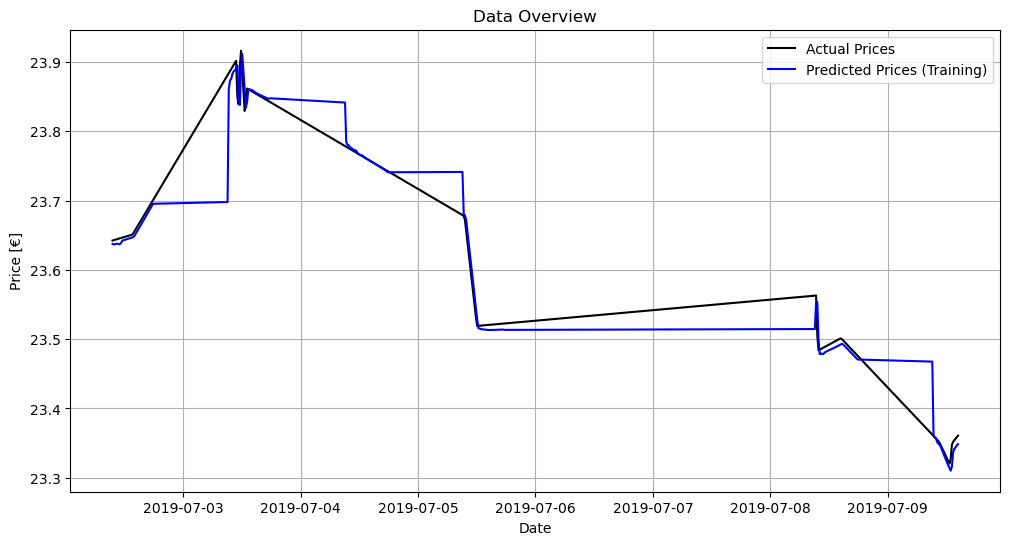

In [193]:
days_to_scrutinize = 200

# plot result:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(dates_train[:days_to_scrutinize], normaliser.inverse_transform(Y_train[:days_to_scrutinize]), label='Actual Prices', color='black')
#ax.plot(dates_train, normaliser.inverse_transform(train_predictions), label='Predicted Prices (Training)', color='blue')
ax.plot(dates[:days_to_scrutinize], normaliser.inverse_transform(predictions[:days_to_scrutinize]), label='Predicted Prices (Training)', color='blue')

ax.set_xlabel('Date')
ax.set_ylabel('Price [€]')
ax.set_title('Data Overview')
ax.grid(True)
ax.legend()

### Save Model

In [197]:
torch.save(LSTMModel, SAVED_MODELS / 'model.pt')

NameError: name 'train_predictions2' is not defined

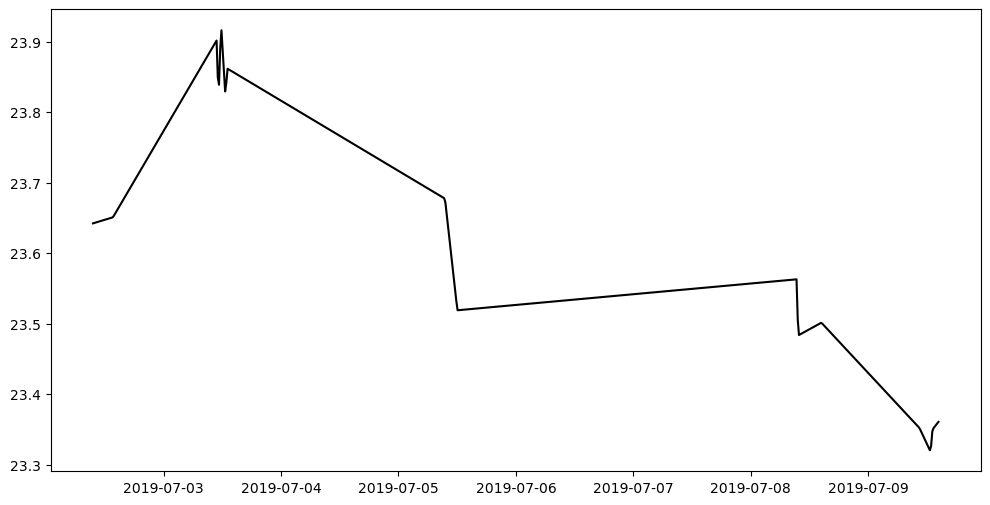

In [195]:
days_to_scrutinize = 200

# plot result:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(dates_train[:days_to_scrutinize], normaliser.inverse_transform(Y_train[:days_to_scrutinize]), label='Actual Prices', color='black')
#ax.plot(dates_train, normaliser.inverse_transform(train_predictions), label='Predicted Prices (Training)', color='blue')
ax.plot(dates_train[:days_to_scrutinize], normaliser.inverse_transform(train_predictions2[:days_to_scrutinize]), label='Predicted Prices (Training)', color='blue')

ax.set_xlabel('Date')
ax.set_ylabel('Price [€]')
ax.set_title('Data Overview')
ax.grid(True)
ax.legend()

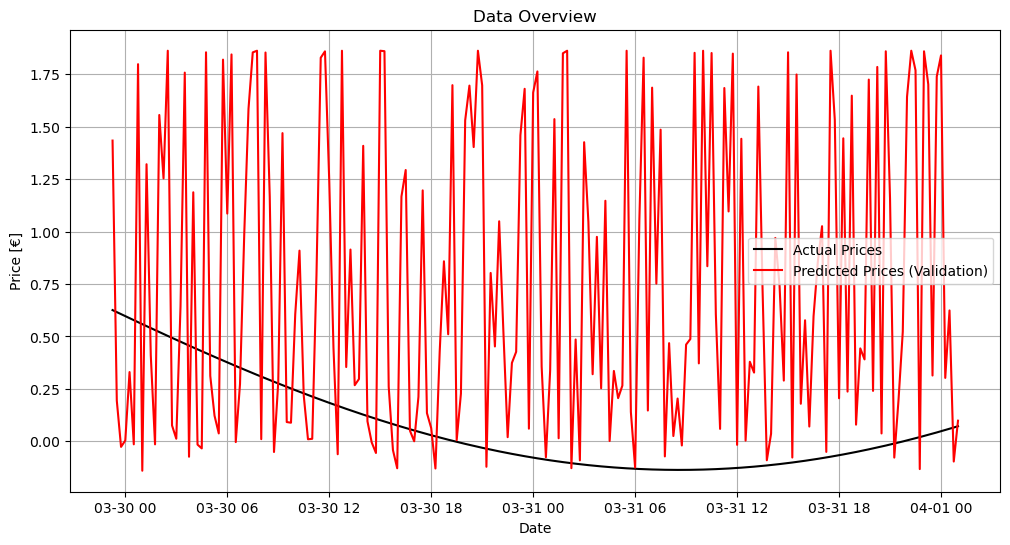

In [91]:
days_to_scrutinize = 200

# plot result:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(dates_val[:days_to_scrutinize], normaliser.inverse_transform(Y_val[:days_to_scrutinize]), label='Actual Prices', color='black')
#ax.plot(dates_train, normaliser.inverse_transform(train_predictions), label='Predicted Prices (Training)', color='blue')
ax.plot(dates_val[:days_to_scrutinize], normaliser.inverse_transform(val_predictions2[:days_to_scrutinize]), label='Predicted Prices (Validation)', color='red')

ax.set_xlabel('Date')
ax.set_ylabel('Price [€]')
ax.set_title('Data Overview')
ax.grid(True)
ax.legend()